<a href="https://colab.research.google.com/github/Marcos-L/Computer-Vision-Workshop/blob/main/Semantic%20Segmentation/Segnet_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segnet
In this notebook, a Segnet neural network is constructed using tensorflow. Two different methods are utilized: Class Inheritance and the keras API.
<div>
<img src="https://www.researchgate.net/profile/Tonmoy-Ghosh/publication/327995579/figure/fig2/AS:799074504687616@1567525616445/The-SegNet-architecture-used-in-bleeding-detection-14.ppm" width="600" alt="Segnet Architecture Diagram"/>
</div>
For the sake of clarity, SegNet can be contruscted in two parts: the Encoder and the Decoder. The Encoder consists of Convolutional layers followed by a MaxPool layer. The Decoder consists of a Upsampling layer (MaxUnPool layer) followed by more Convolutional Layers. Finally, a Softmax layer is added for multiclass classificaion, but can be exchanged for a Sigmoid in the case of single class classification.

## Installation of complementary code

In [2]:
!git clone https://github.com/Rmejiaz/Feet_U-Net

Cloning into 'Feet_U-Net'...
remote: Enumerating objects: 1023, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 1023 (delta 29), reused 39 (delta 21), pack-reused 971
Receiving objects: 100% (1023/1023), 40.83 MiB | 27.53 MiB/s, done.
Resolving deltas: 100% (344/344), done.


In [3]:
cd  /content/Feet_U-Net/UNet

/content/Feet_U-Net/UNet


##Imports


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.compat.v1 import variable_scope
from keras import backend as K
from keras.layers import Layer
import utils

## Custom Layers

Tensorflow lacks the upsampling layer needed for segnet, so we construct one here

Credit: https://github.com/ykamikawa/tf-keras-SegNet

In [5]:
class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size
    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )


## Download the most recent version of the Dataset

In [6]:
!python download_dataset.py

sed: -e expression #1, char 31: unterminated `s' command
--2022-08-08 15:18:14--  https://docs.google.com/uc?export=download&confirm=&id=1IXtHeATb8KsMzp-tEuLCdeMB57n1U_qQ
Resolving docs.google.com (docs.google.com)... 74.125.142.101, 74.125.142.102, 74.125.142.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oanoor9m2rv6ub05atkv19iaksbnhh1n/1659971850000/10854142796765961935/*/1IXtHeATb8KsMzp-tEuLCdeMB57n1U_qQ?e=download&uuid=52937c85-3f52-4975-9c6f-c6e9d1270145 [following]
--2022-08-08 15:18:16--  https://doc-0g-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oanoor9m2rv6ub05atkv19iaksbnhh1n/1659971850000/10854142796765961935/*/1IXtHeATb8KsMzp-tEuLCdeMB57n1U_qQ?e=download&uuid=52937c85-3f52-4975-9c6f-c6e9d1270145
Resolving doc-0g-40-docs.googleusercontent.com (d

Once the Dataset has been downloaded, we can use the load_data in the utils.py file to load and rescale the images.

The Dataset already splits the images into the Train and Test folder, so we simply need to load each folder into a different variable.

In [7]:
# 224 is the width and height of the rescaled images
X_Train = utils.load_data('Dataset_3/Train/JPEGImages',224) 

# The Segmentation class images are PNG (4 layer images), 
# but since this dataset is single class we only need 1 layer
Y_Train = utils.load_data('Dataset_3/Train/SegmentationClass',224)[...,0]

# Y has the shape (n,224,224), this line of code changes the shape (n,224,224,1)
Y_Train = np.expand_dims(Y_Train,-1) 
Y_Train[Y_Train != 0] = 1

X_Test = utils.load_data('Dataset_3/Test/JPEGImages',224)
Y_Test = utils.load_data('Dataset_3/Test/SegmentationClass',224)[...,0]
Y_Test = np.expand_dims(Y_Test,-1)
Y_Test[Y_Test != 0] = 1

In [8]:
print(Y_Train.shape)
print(Y_Test.shape)
Y_Test.shape[0]/(Y_Train.shape[0]+Y_Test.shape[0]) #We make sure we are using about 10% of our data for testing

(148, 224, 224, 1)
(18, 224, 224, 1)


0.10843373493975904

## Model Construction with class inheritance

The following code creates the Class SegNet which inherits the properties of the tf.keras.Model class.

In [ ]:
class SegNet(tf.keras.Model):
  def __init__(self, ActFunction = 'relu'):
    kernel = 3
    n_labels = 1
    super(SegNet, self).__init__()
    self.Input = InputLayer(input_shape=(224,224,3), name='Input', sparse=False, ragged=False)
    #***********************************************************************Encoder***********************************************************************
    self.Conv1 = Conv2D(filters=64, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv1')
    self.Norm1 = BatchNormalization(name='Norm1')
    self.Act1 = Activation(ActFunction, name=ActFunction+'1')
    self.Conv2 = Conv2D(filters=64, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv2')
    self.Norm2 = BatchNormalization(name='Norm2')
    self.Act2 = Activation(ActFunction, name=ActFunction+'2')
    self.Maxpool1 = MaxPoolingWithArgmax2D(name='Max2DArgmax1')

    self.Conv3 = Conv2D(filters=128, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv3')
    self.Norm3 = BatchNormalization(name='Norm3')
    self.Act3 = Activation(ActFunction, name=ActFunction+'3')
    self.Conv4 = Conv2D(filters=128, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv4')
    self.Norm4 = BatchNormalization(name='Norm4')
    self.Act4 = Activation(ActFunction, name=ActFunction+'4')
    self.Maxpool2 = MaxPoolingWithArgmax2D(name='Max2DArgmax2')

    self.Conv5 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv5')
    self.Norm5 = BatchNormalization(name='Norm5')
    self.Act5 = Activation(ActFunction, name=ActFunction+'5')
    self.Conv6 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv6')
    self.Norm6 = BatchNormalization(name='Norm6')
    self.Act6 = Activation(ActFunction, name=ActFunction+'6')
    self.Conv7 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv7')
    self.Norm7 = BatchNormalization(name='Norm7')
    self.Act7 = Activation(ActFunction, name=ActFunction+'7')
    self.Maxpool3 = MaxPoolingWithArgmax2D(name='Max2DArgmax3')

    self.Conv8 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv8')
    self.Norm8 = BatchNormalization(name='Norm8')
    self.Act8 = Activation(ActFunction, name=ActFunction+'8')
    self.Conv9 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv9')
    self.Norm9 = BatchNormalization(name='Norm9')
    self.Act9 = Activation(ActFunction, name=ActFunction+'9')
    self.Conv10 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv10')
    self.Norm10 = BatchNormalization(name='Norm10')
    self.Act10 = Activation(ActFunction, name=ActFunction+'10')
    self.Maxpool4 = MaxPoolingWithArgmax2D(name='Max2DArgmax4')

    self.Conv11 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv11')
    self.Norm11 = BatchNormalization(name='Norm11')
    self.Act11 = Activation(ActFunction, name=ActFunction+'11')
    self.Conv12 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv12')
    self.Norm12 = BatchNormalization(name='Norm12')
    self.Act12 = Activation(ActFunction, name=ActFunction+'12')
    self.Conv13 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv13')
    self.Norm13 = BatchNormalization(name='Norm13')
    self.Act13 = Activation(ActFunction, name=ActFunction+'13')
    self.Maxpool5 = MaxPoolingWithArgmax2D(name='Max2DArgmax5')

  #******************************************************************Decoder*****************************************************************************************
    self.UnPool5 = MaxUnpooling2D(name='Unpool5')
    self.Conv14 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv14')
    self.Norm14 = BatchNormalization(name='Norm14')
    self.Act14 = Activation(ActFunction, name=ActFunction+'14')
    self.Conv15 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv15')
    self.Norm15 = BatchNormalization(name='Norm15')
    self.Act15 = Activation(ActFunction, name=ActFunction+'15')
    self.Conv16 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv16')
    self.Norm16 = BatchNormalization(name='Norm16')
    self.Act16 = Activation(ActFunction, name=ActFunction+'16')

    self.UnPool4 = MaxUnpooling2D(name='Unpool4')
    self.Conv17 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv17')
    self.Norm17 = BatchNormalization(name='Norm17')
    self.Act17 = Activation(ActFunction, name=ActFunction+'17')
    self.Conv18 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv18')
    self.Norm18 = BatchNormalization(name='Norm18')
    self.Act18 = Activation(ActFunction, name=ActFunction+'18')
    self.Conv19 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv19')
    self.Norm19 = BatchNormalization(name='Norm19')
    self.Act19 = Activation(ActFunction, name=ActFunction+'19')

    self.UnPool3 = MaxUnpooling2D(name='Unpool3')
    self.Conv20 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv20')
    self.Norm20 = BatchNormalization(name='Norm20')
    self.Act20 = Activation(ActFunction, name=ActFunction+'20')
    self.Conv21 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv21')
    self.Norm21 = BatchNormalization(name='Norm21')
    self.Act21 = Activation(ActFunction, name=ActFunction+'21')
    self.Conv22 = Conv2D(filters=128, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv22')
    self.Norm22 = BatchNormalization(name='Norm22')
    self.Act22 = Activation(ActFunction, name=ActFunction+'22')

    self.UnPool2 = MaxUnpooling2D(name='Unpool2')
    self.Conv23 = Conv2D(filters=128, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv23')
    self.Norm23 = BatchNormalization(name='Norm23')
    self.Act23 = Activation(ActFunction, name=ActFunction+'23')
    self.Conv24 = Conv2D(filters=64, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv24')
    self.Norm24 = BatchNormalization(name='Norm24')
    self.Act24 = Activation(ActFunction, name=ActFunction+'24')

    self.UnPool1 = MaxUnpooling2D(name='Unpool1')
    self.Conv25 = Conv2D(filters=64, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv25')
    self.Norm25 = BatchNormalization(name='Norm25')
    self.Act25 = Activation(ActFunction, name=ActFunction+'25')
    self.Conv26 = Conv2D(filters=n_labels, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv26')
    self.Norm26 = BatchNormalization(name='Norm26')
    
    self.Out = Activation('sigmoid', name='OutputLayer')

  def call(self, inputs):
    x = self.Input(inputs)
    conv1 = self.Conv1(x)
    conv1 = self.Norm1(conv1)
    conv1 = self.Act1(conv1)
    conv2 = self.Conv2(conv1)
    conv2 = self.Norm2(conv2)
    conv2 = self.Act2(conv2)
    pool1, argmax1 = self.Maxpool1(conv2)

    conv3 = self.Conv3(pool1)
    conv3 = self.Norm3(conv3)
    conv3 = self.Act3(conv3)
    conv4 = self.Conv4(conv3)
    conv4 = self.Norm4(conv4)
    conv4 = self.Act4(conv4)
    pool2, argmax2 = self.Maxpool1(conv4)

    conv5 = self.Conv5(pool2)
    conv5 = self.Norm5(conv5)
    conv5 = self.Act5(conv5)
    conv6 = self.Conv6(conv5)
    conv6 = self.Norm6(conv6)
    conv6 = self.Act6(conv6)
    conv7 = self.Conv7(conv6)
    conv7 = self.Norm7(conv7)
    conv7 = self.Act7(conv7)
    pool3, argmax3 = self.Maxpool1(conv7)

    conv8 = self.Conv8(pool3)
    conv8 = self.Norm8(conv8)
    conv8 = self.Act8(conv8)
    conv9 = self.Conv9(conv8)
    conv9 = self.Norm9(conv9)
    conv9 = self.Act9(conv9)
    conv10 = self.Conv10(conv9)
    conv10 = self.Norm10(conv10)
    conv10 = self.Act10(conv10)
    pool4, argmax4 = self.Maxpool1(conv10)

    conv11 = self.Conv11(pool4)
    conv11 = self.Norm11(conv11)
    conv11 = self.Act11(conv11)
    conv12 = self.Conv12(conv11)
    conv12 = self.Norm12(conv12)
    conv12 = self.Act12(conv12)
    conv13 = self.Conv13(conv12)
    conv13 = self.Norm13(conv13)
    conv13 = self.Act13(conv13)
    pool5, argmax5 = self.Maxpool1(conv13)


    unpool5 = self.UnPool5([pool5,argmax5],tf.shape(conv13))
    conv14 = self.Conv14(unpool5)
    conv14 = self.Norm14(conv14)
    conv14 = self.Act14(conv14)
    conv15 = self.Conv15(conv14)
    conv15 = self.Norm15(conv15)
    conv15 = self.Act15(conv15)
    conv16 = self.Conv16(conv15)
    conv16 = self.Norm16(conv16)
    conv16 = self.Act16(conv16)

    unpool4 = self.UnPool4([conv16,argmax4], tf.shape(conv10))
    conv17 = self.Conv17(unpool4)
    conv17 = self.Norm17(conv17)
    conv17 = self.Act17(conv17)
    conv18 = self.Conv18(conv17)
    conv18 = self.Norm18(conv18)
    conv18 = self.Act18(conv18)
    conv19 = self.Conv19(conv18)
    conv19 = self.Norm19(conv19)
    conv19 = self.Act19(conv19)

    unpool3 = self.UnPool3([conv19,argmax3], tf.shape(conv7))
    conv20 = self.Conv20(unpool3)
    conv20 = self.Norm20(conv20)
    conv20 = self.Act20(conv20)
    conv21 = self.Conv21(conv20)
    conv21 = self.Norm21(conv21)
    conv21 = self.Act21(conv21)
    conv22 = self.Conv22(conv21)
    conv22 = self.Norm22(conv22)
    conv22 = self.Act22(conv22)

    unpool2 = self.UnPool2([conv22,argmax2], tf.shape(conv4))
    conv23 = self.Conv23(unpool2)
    conv23 = self.Norm23(conv23)
    conv23 = self.Act23(conv23)
    conv24 = self.Conv24(conv23)
    conv24 = self.Norm24(conv24)
    conv24 = self.Act24(conv24)

    unpool1 = self.UnPool1([conv24,argmax1],tf.shape(conv2))
    conv25 = self.Conv25(unpool1)
    conv25 = self.Norm25(conv25)
    conv25 = self.Act25(conv25)
    conv26 = self.Conv26(conv25)
    conv26 = self.Norm26(conv26)
    output = self.Out(conv26)
    return output

###Build

Model: "seg_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Conv1 (Conv2D)              multiple                  1792      
                                                                 
 Norm1 (BatchNormalization)  multiple                  256       
                                                                 
 selu1 (Activation)          multiple                  0         
                                                                 
 Conv2 (Conv2D)              multiple                  36928     
                                                                 
 Norm2 (BatchNormalization)  multiple                  256       
                                                                 
 selu2 (Activation)          multiple                  0 

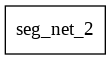

In [ ]:
input_shape = (None,224, 224, 3)
Seg = SegNet('selu')
Seg.build(input_shape)
Seg.summary()
tf.keras.utils.plot_model(Seg)

###Compile

In [ ]:
Seg.compile(
                optimizer = tf.keras.optimizers.Adam(), #Probar con SGD - Dio peor
                metrics = [utils.dice_coef, utils.iou_coef],
                loss = tf.keras.losses.BinaryCrossentropy()
                )

###Fit

In [ ]:
segnet_hist = Seg.fit(
                                x = X_Train,
                                y = Y_Train,
                                validation_data = (X_Test,Y_Test),
                                epochs = 180,
                                batch_size = 5
                                )

Epoch 1/180
30/30 [==============================] - 29s 373ms/step - loss: 0.7234 - dice_coef: 0.3711 - iou_coef: 0.2371 - val_loss: 335723.7812 - val_dice_coef: 0.5531 - val_iou_coef: 0.3827
Epoch 2/180
30/30 [==============================] - 10s 349ms/step - loss: 0.5803 - dice_coef: 0.4359 - iou_coef: 0.2897 - val_loss: 438.0255 - val_dice_coef: 0.5591 - val_iou_coef: 0.3885
Epoch 3/180
30/30 [==============================] - 10s 350ms/step - loss: 0.5488 - dice_coef: 0.4435 - iou_coef: 0.2965 - val_loss: 71.0566 - val_dice_coef: 0.5585 - val_iou_coef: 0.3878
Epoch 4/180
30/30 [==============================] - 10s 350ms/step - loss: 0.5230 - dice_coef: 0.4526 - iou_coef: 0.3045 - val_loss: 7.9628 - val_dice_coef: 0.6004 - val_iou_coef: 0.4296
Epoch 5/180
30/30 [==============================] - 10s 350ms/step - loss: 0.5076 - dice_coef: 0.4635 - iou_coef: 0.3138 - val_loss: 4.7891 - val_dice_coef: 0.5937 - val_iou_coef: 0.4228
Epoch 6/180
30/30 [==============================] -

Max Dice:  94.97093558311462


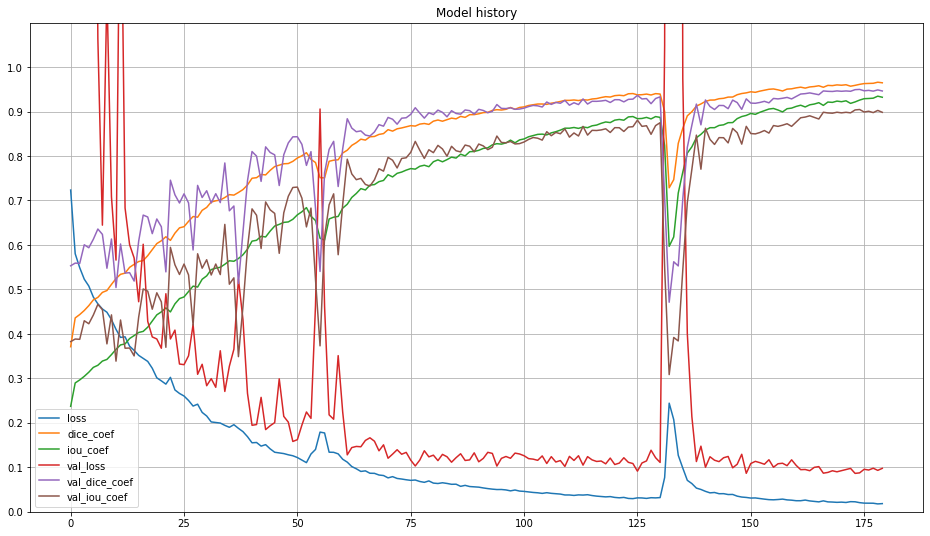

In [ ]:
plt.figure(figsize=(16,9))
for i in segnet_hist.history:
    plt.plot(segnet_hist.history[i],label=i)
plt.yticks(np.arange(0,1.1,0.1))
plt.ylim(0,1.1)
plt.title('Model history')
plt.legend()
plt.grid()
print('Max Dice: ', max(segnet_hist.history['val_dice_coef'])*100)

###Predict

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t0.jpg
Dice: 0.9651541543285141
Jaccard: 0.9326550020619251


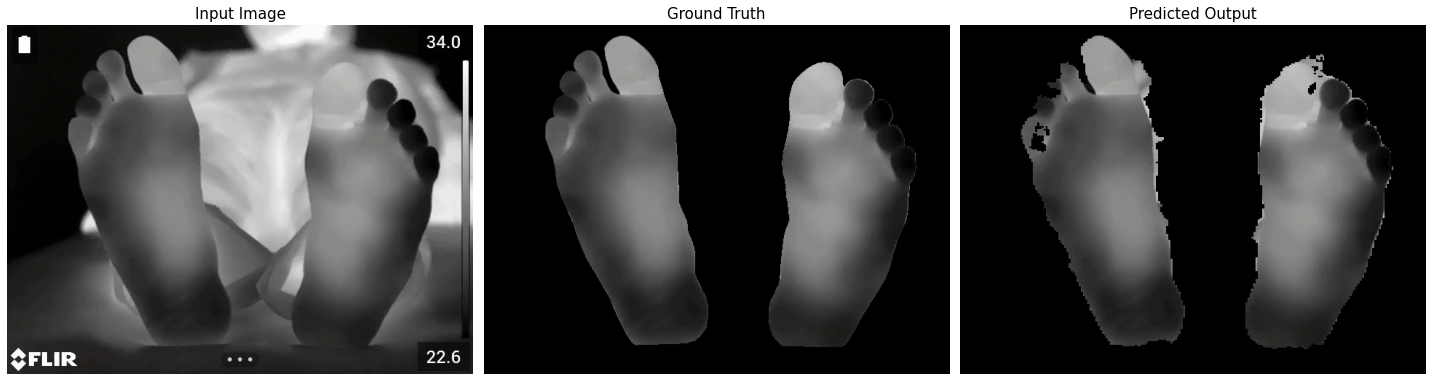

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t1.jpg
Dice: 0.9477230874161646
Jaccard: 0.9006403885542429


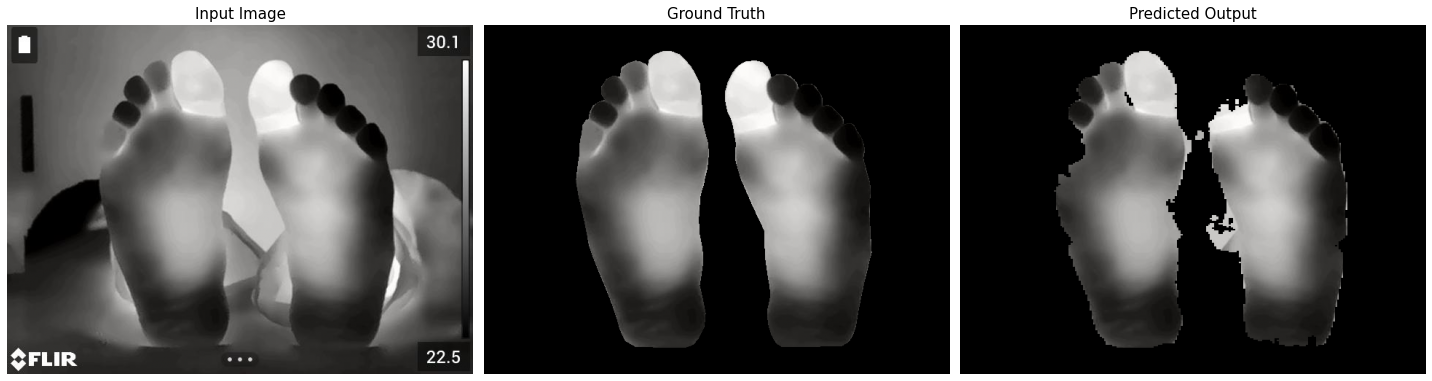

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t10.jpg
Dice: 0.9588340959721883
Jaccard: 0.9209234496278469


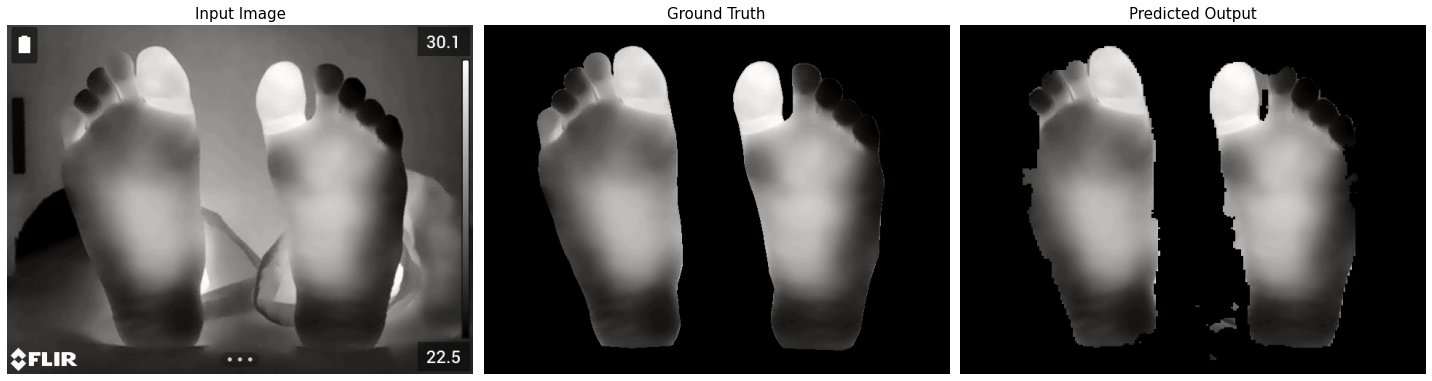

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t15.jpg
Dice: 0.9669652526507552
Jaccard: 0.9360432987680005


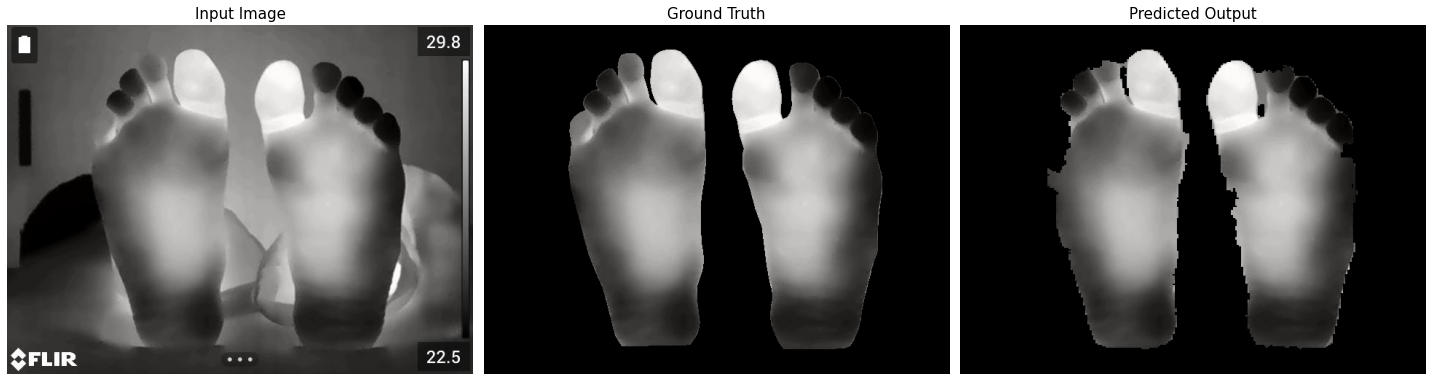

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t20.jpg
Dice: 0.9652640402347025
Jaccard: 0.9328602443213116


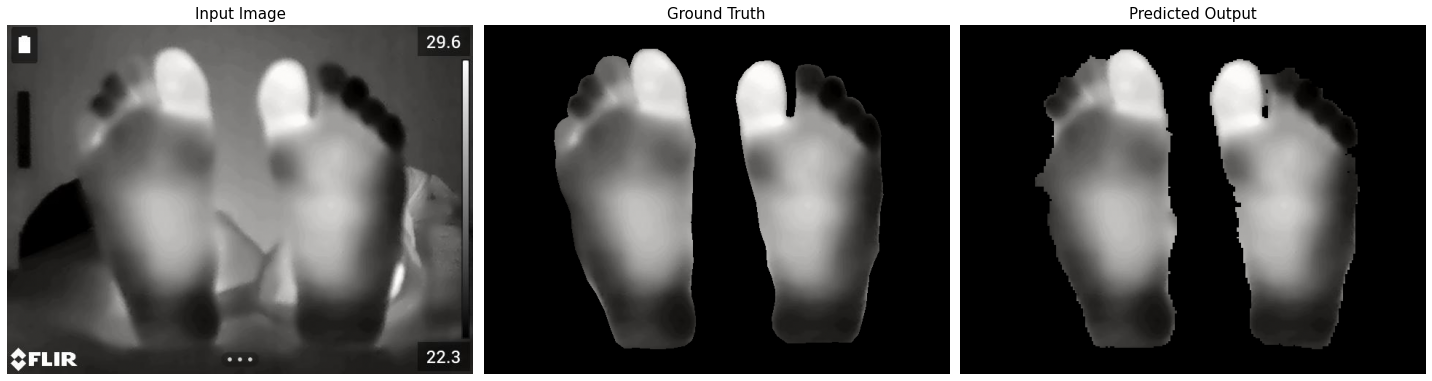

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t25.jpg
Dice: 0.970564876817228
Jaccard: 0.9428130583076173


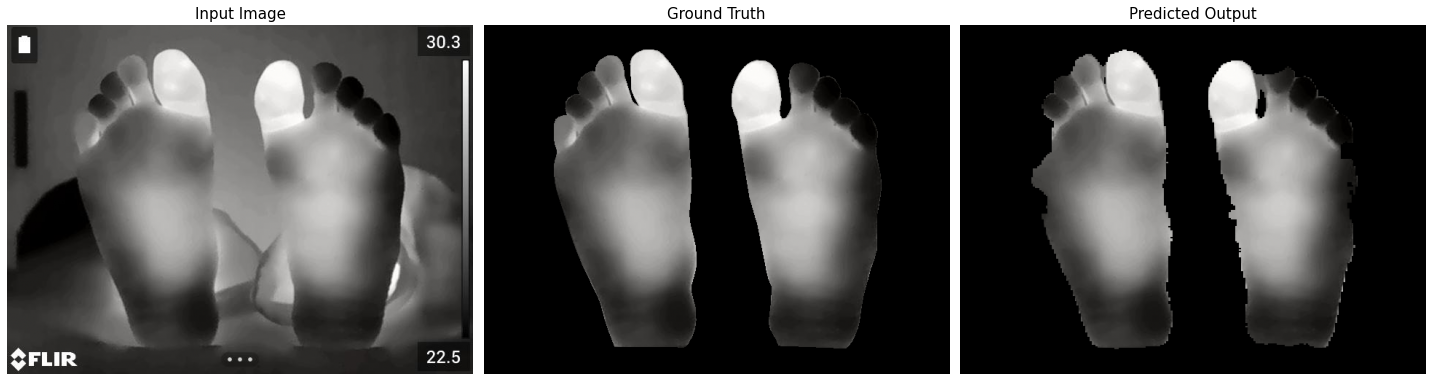

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t30.jpg
Dice: 0.9700853446287404
Jaccard: 0.9419084771437181


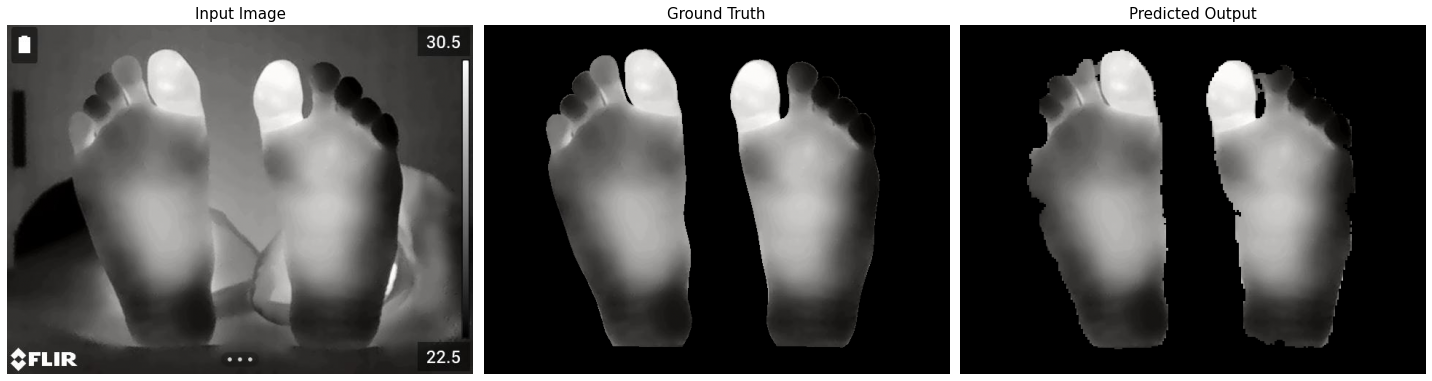

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t35.jpg
Dice: 0.9745364751182355
Jaccard: 0.9503375317328806


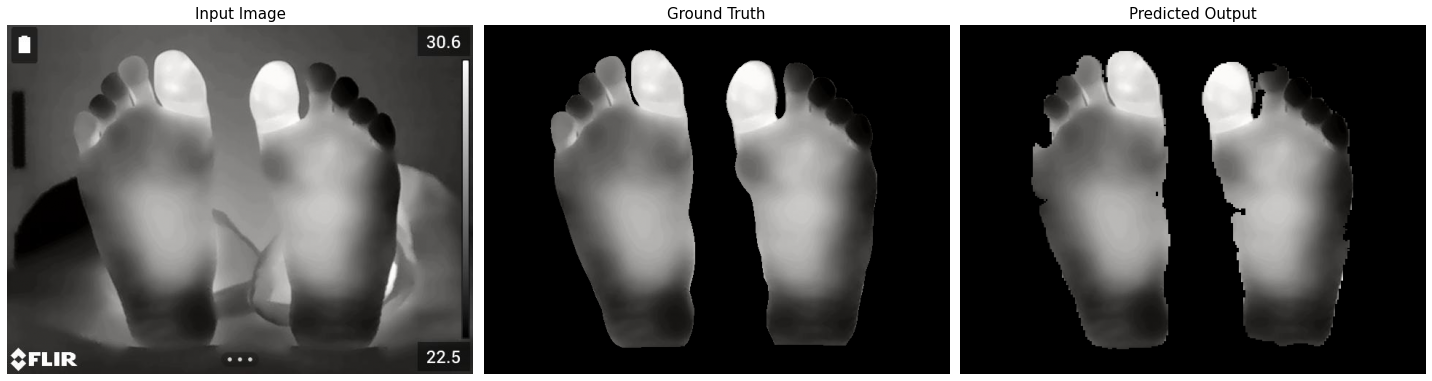

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t40.jpg
Dice: 0.9727518842226641
Jaccard: 0.946949300059379


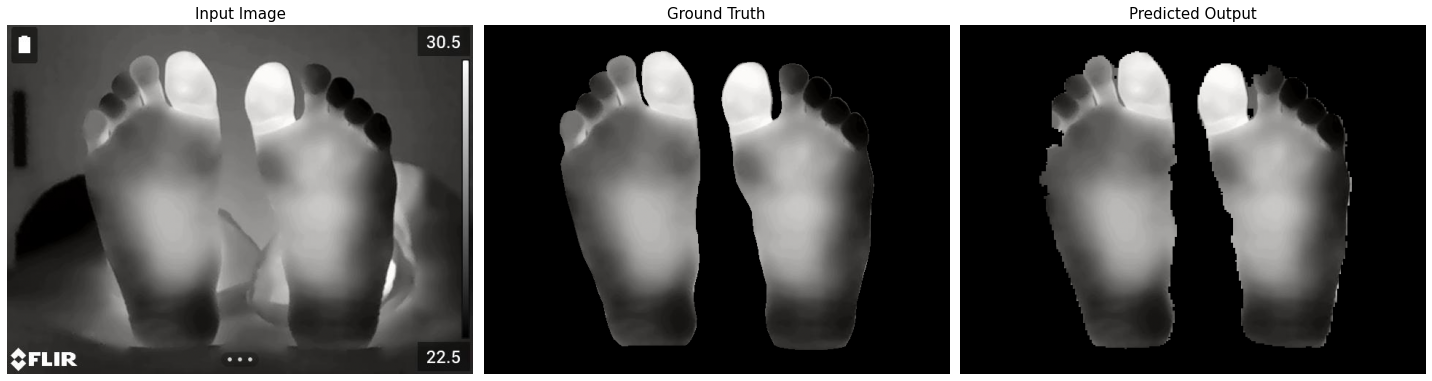

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t45.jpg
Dice: 0.9707962859811283
Jaccard: 0.9432498860602904


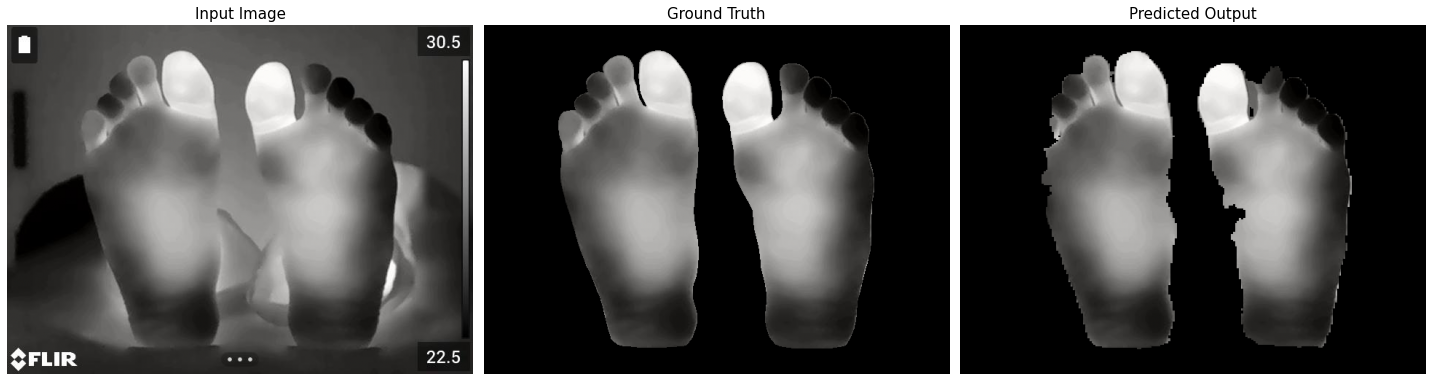

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t5.jpg
Dice: 0.9686250564598424
Jaccard: 0.9391589959855643


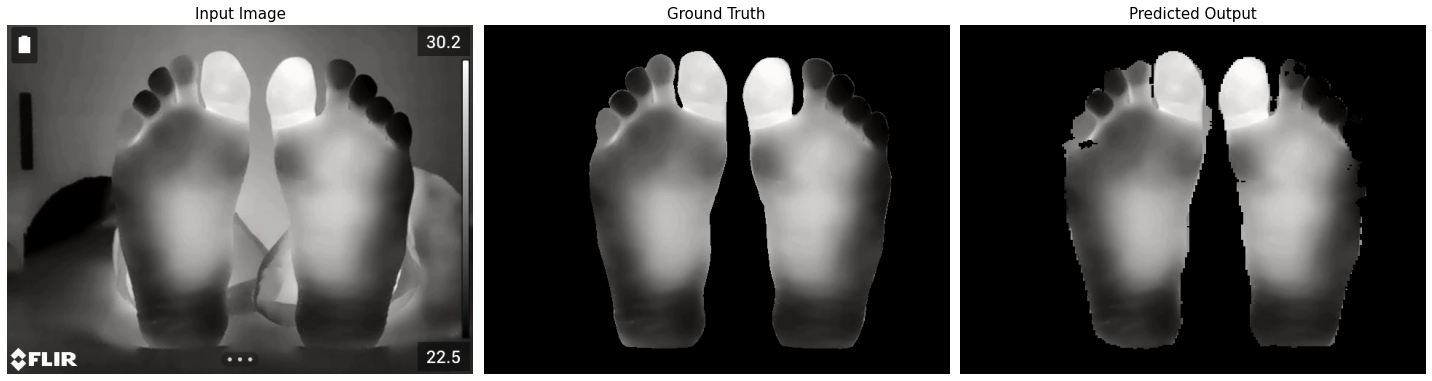

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t50.jpg
Dice: 0.9779001796664782
Jaccard: 0.9567560430128824


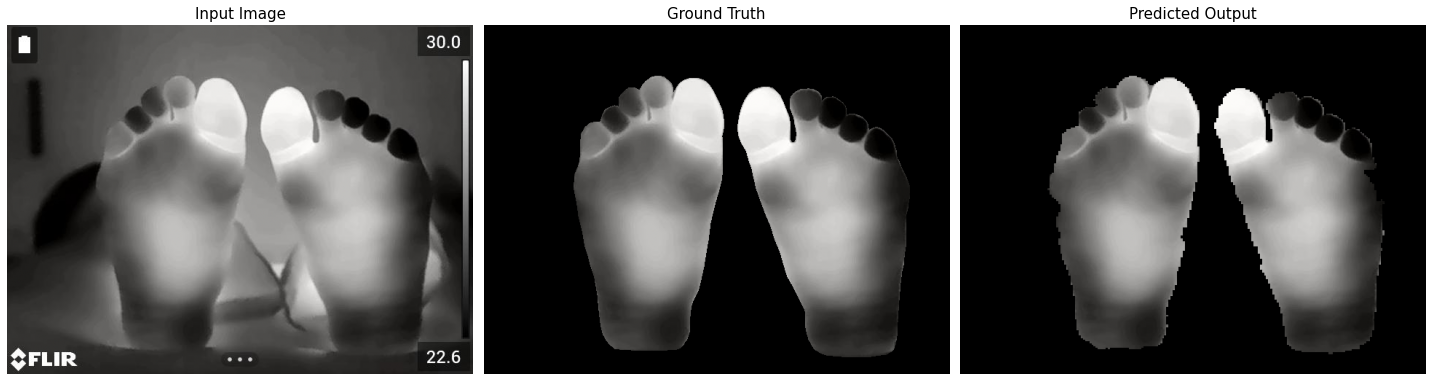

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t55.jpg
Dice: 0.9679017591569644
Jaccard: 0.9378000279957512


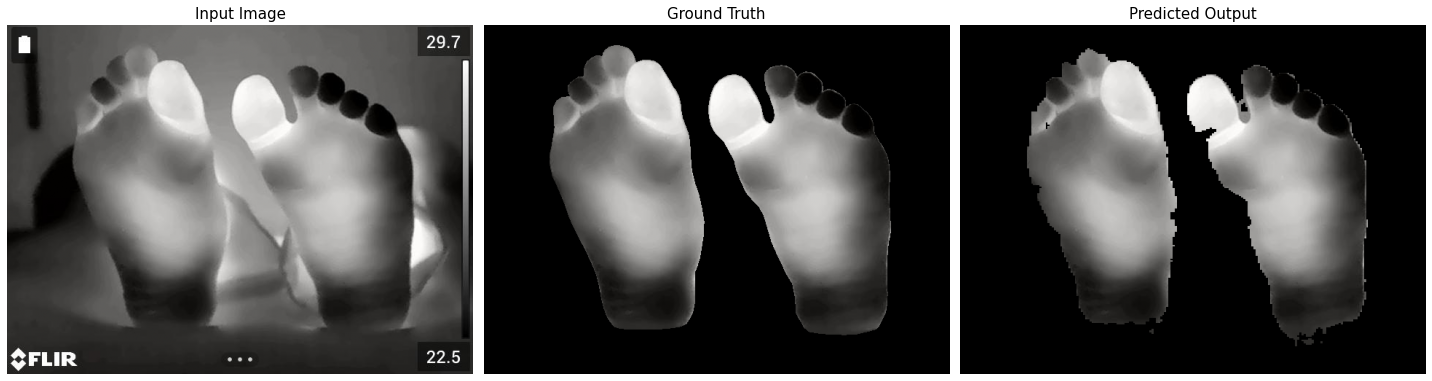

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t60.jpg
Dice: 0.9596244756087927
Jaccard: 0.9223827868983487


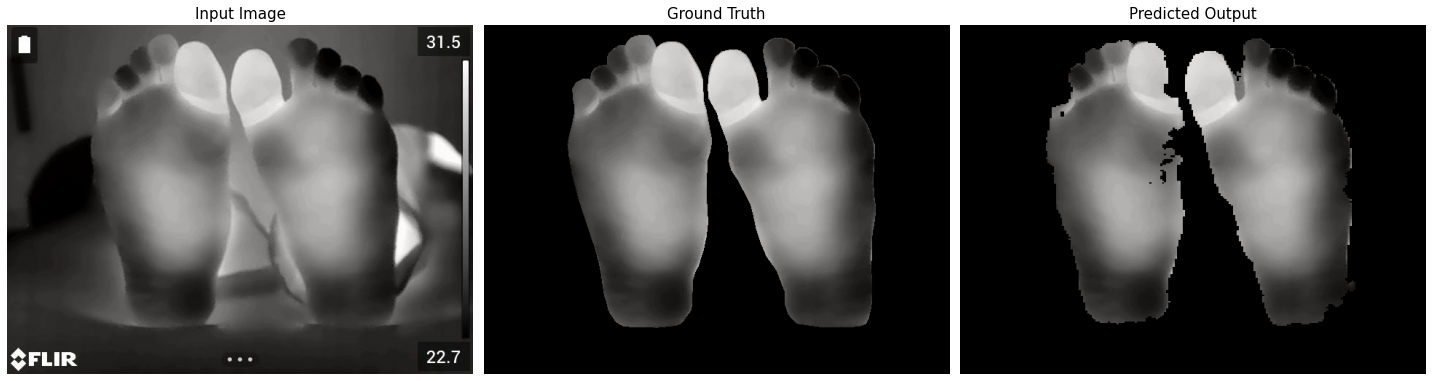

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t65.jpg
Dice: 0.9587800268924664
Jaccard: 0.9208236987915013


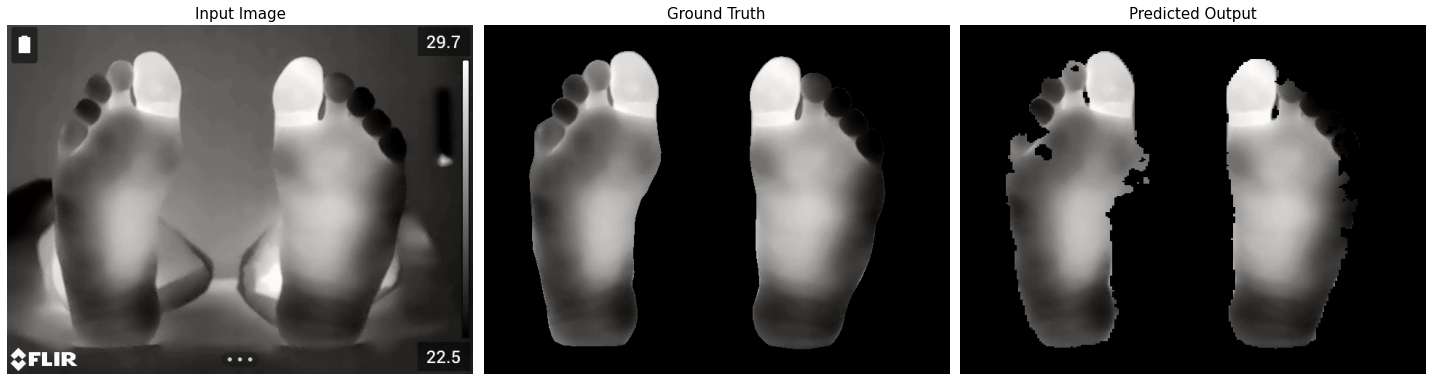

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t70.jpg
Dice: 0.9644533678879443
Jaccard: 0.9313471146353761


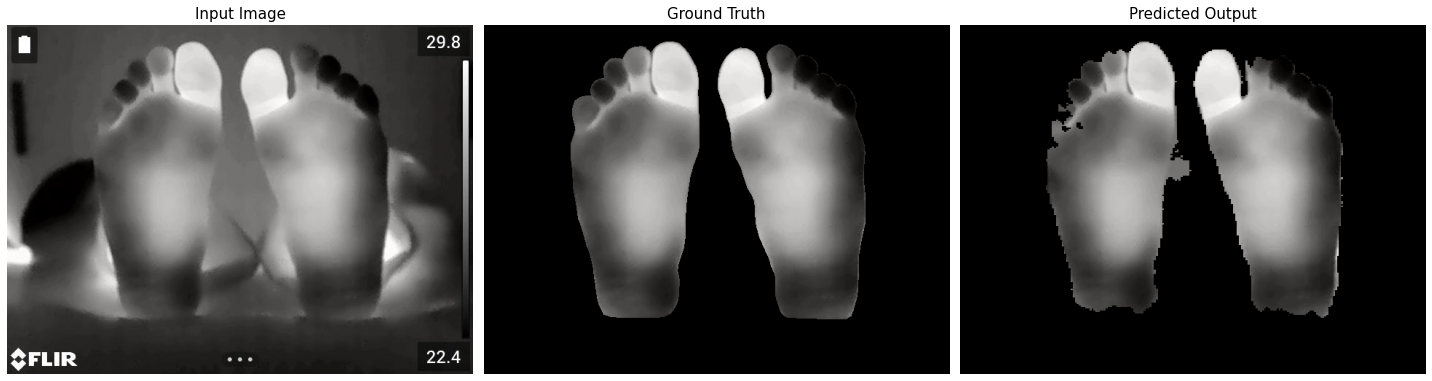

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t75.jpg
Dice: 0.9248717770657037
Jaccard: 0.8602432317714581


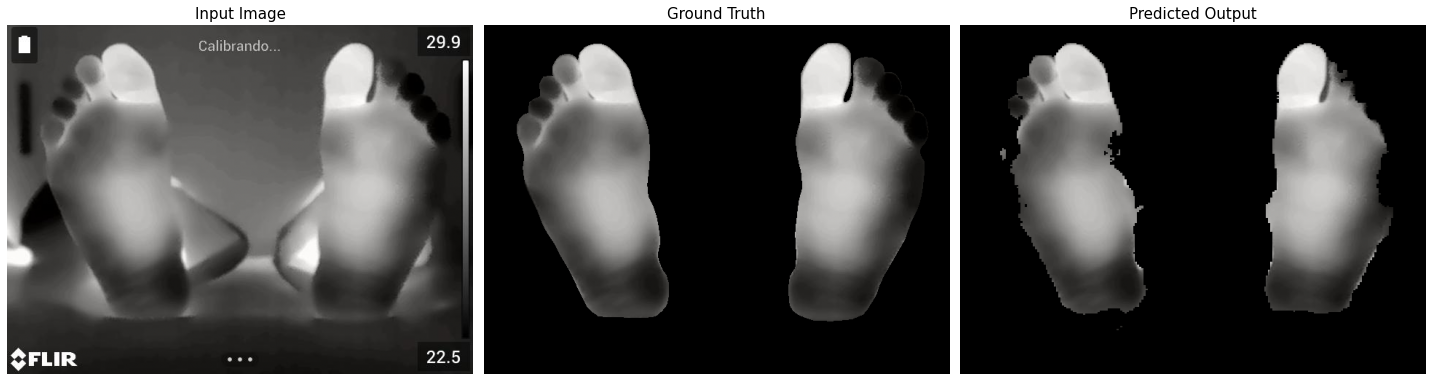

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t80.jpg
Dice: 0.9545232080443348
Jaccard: 0.9130027709738129


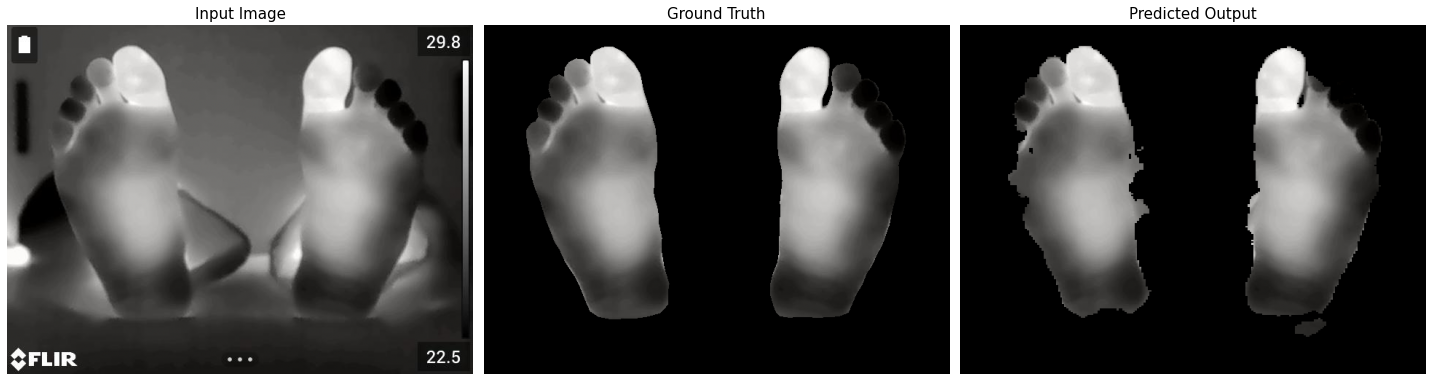

In [ ]:
img_size = 224
images_path = './Dataset_3/Test/JPEGImages' 
masks_path = './Dataset_3/Test/SegmentationClass'
imgs = os.listdir(images_path)
imgs.sort()
DiceList = []
JList = []
for n in range(len(imgs)):
    img_path = os.path.join(images_path, imgs[n])
    mask_path = os.path.join(masks_path, f"{imgs[n][:-3]}png")
   
    # Read the image
    img = plt.imread(img_path)/255.
    X = tf.convert_to_tensor(img)
    X = tf.image.resize(X,(img_size,img_size))
    X = tf.expand_dims(X,0)

    Y = plt.imread(mask_path)[:,:,0]

    # Make the prediction
    threshold = 0.5
    Y_pred = Seg.predict(X)   
    Y_pred = Y_pred/Y_pred.max()
    Y_pred = np.where(Y_pred>=threshold,1,0)
    # Resize
    Y_pred = cv2.resize(Y_pred[0], (img.shape[1],img.shape[0]), interpolation = cv2.INTER_NEAREST) # Resize the prediction to have the same dimensions as the input
    Dice = utils.DiceSimilarity(Y, Y_pred)
    DiceList += [Dice]
    Jaccard = utils.jaccard(Y, Y_pred)
    JList += [Jaccard]
    print(f"Displaying {img_path}\nDice: {Dice}\nJaccard: {Jaccard}")

    
    plt.figure(figsize=(20,9))

    if (img.shape[-1] == 3):
        mask = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
        pred_mask = np.copy(mask)
        mask[:,:,0] = mask[:,:,1] = mask[:,:,2] = Y[:,:]
        pred_mask[:,:,0] = pred_mask[:,:,1] = pred_mask[:,:,2] = Y_pred[:,:]
    else:
        mask = Y
        pred_mask = Y_pred

    plt.subplot(131)
    plt.imshow(img)
    plt.title("Input Image", fontsize=15)
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(img*mask,cmap='gray')
    plt.title("Ground Truth",fontsize=15)
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img*pred_mask,cmap='gray')
    plt.title("Predicted Output",fontsize=15)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

##With API


###Build

In [ ]:
#Volver a armar la red pero esta vez usando API
kernel = 3
n_labels = 1
ActFunction = 'selu'
input_shape = (None,224,224,3)
Input = tf.keras.Input(shape=(224,224,3), name='Input')
#***********************************************************************Encoder***********************************************************************
Conv1 = Conv2D(filters=64, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv1')(Input)
Norm1 = BatchNormalization(name='Norm1')(Conv1)
Act1 = Activation(ActFunction, name=ActFunction+'1')(Norm1)
Conv2 = Conv2D(filters=64, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv2')(Act1)
Norm2 = BatchNormalization(name='Norm2')(Conv2)
Act2 = Activation(ActFunction, name=ActFunction+'2')(Norm2)
Maxpool1, Argmax1 = MaxPoolingWithArgmax2D(name='Max2DArgmax1')(Act2)

Conv3 = Conv2D(filters=128, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv3')(Maxpool1)
Norm3 = BatchNormalization(name='Norm3')(Conv3)
Act3 = Activation(ActFunction, name=ActFunction+'3')(Norm3)
Conv4 = Conv2D(filters=128, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv4')(Act3)
Norm4 = BatchNormalization(name='Norm4')(Conv4)
Act4 = Activation(ActFunction, name=ActFunction+'4')(Norm4)
Maxpool2, Argmax2 = MaxPoolingWithArgmax2D(name='Max2DArgmax2')(Act4)

Conv5 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv5')(Maxpool2)
Norm5 = BatchNormalization(name='Norm5')(Conv5)
Act5 = Activation(ActFunction, name=ActFunction+'5')(Norm5)
Conv6 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv6')(Act5)
Norm6 = BatchNormalization(name='Norm6')(Conv6)
Act6 = Activation(ActFunction, name=ActFunction+'6')(Norm6)
Conv7 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv7')(Act6)
Norm7 = BatchNormalization(name='Norm7')(Conv7)
Act7 = Activation(ActFunction, name=ActFunction+'7')(Norm7)
Maxpool3, Argmax3 = MaxPoolingWithArgmax2D(name='Max2DArgmax3')(Act7)

Conv8 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv8')(Maxpool3)
Norm8 = BatchNormalization(name='Norm8')(Conv8)
Act8 = Activation(ActFunction, name=ActFunction+'8')(Norm8)
Conv9 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv9')(Act8)
Norm9 = BatchNormalization(name='Norm9')(Conv9)
Act9 = Activation(ActFunction, name=ActFunction+'9')(Norm9)
Conv10 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv10')(Act9)
Norm10 = BatchNormalization(name='Norm10')(Conv10)
Act10 = Activation(ActFunction, name=ActFunction+'10')(Norm10)
Maxpool4, Argmax4 = MaxPoolingWithArgmax2D(name='Max2DArgmax4')(Act10)

Conv11 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv11')(Maxpool4)
Norm11 = BatchNormalization(name='Norm11')(Conv11)
Act11 = Activation(ActFunction, name=ActFunction+'11')(Norm11)
Conv12 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv12')(Act11)
Norm12 = BatchNormalization(name='Norm12')(Conv12)
Act12 = Activation(ActFunction, name=ActFunction+'12')(Norm12)
Conv13 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv13')(Act12)
Norm13 = BatchNormalization(name='Norm13')(Conv13)
Act13 = Activation(ActFunction, name=ActFunction+'13')(Norm13)
Maxpool5, Argmax5 = MaxPoolingWithArgmax2D(name='Max2DArgmax5')(Act13)

#******************************************************************Decoder*****************************************************************************************
UnPool5 = MaxUnpooling2D(name='Unpool5')([Maxpool5, Argmax5], tf.shape(Conv13))
Conv14 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv14')(UnPool5)
Norm14 = BatchNormalization(name='Norm14')(Conv14)
Act14 = Activation(ActFunction, name=ActFunction+'14')(Norm14)
Conv15 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv15')(Act14)
Norm15 = BatchNormalization(name='Norm15')(Conv15)
Act15 = Activation(ActFunction, name=ActFunction+'15')(Norm15)
Conv16 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv16')(Act15)
Norm16 = BatchNormalization(name='Norm16')(Conv16)
Act16 = Activation(ActFunction, name=ActFunction+'16')(Norm16)

UnPool4 = MaxUnpooling2D(name='Unpool4')([Act16, Argmax4], tf.shape(Conv10))
Conv17 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv17')(UnPool4)
Norm17 = BatchNormalization(name='Norm17')(Conv17)
Act17 = Activation(ActFunction, name=ActFunction+'17')(Norm17)
Conv18 = Conv2D(filters=512, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv18')(Act17)
Norm18 = BatchNormalization(name='Norm18')(Conv18)
Act18 = Activation(ActFunction, name=ActFunction+'18')(Norm18)
Conv19 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv19')(Act18)
Norm19 = BatchNormalization(name='Norm19')(Conv19)
Act19 = Activation(ActFunction, name=ActFunction+'19')(Norm19)

UnPool3 = MaxUnpooling2D(name='Unpool3')([Act19, Argmax3], tf.shape(Conv7))
Conv20 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv20')(UnPool3)
Norm20 = BatchNormalization(name='Norm20')(Conv20)
Act20 = Activation(ActFunction, name=ActFunction+'20')(Norm20)
Conv21 = Conv2D(filters=256, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv21')(Act20)
Norm21 = BatchNormalization(name='Norm21')(Conv21)
Act21 = Activation(ActFunction, name=ActFunction+'21')(Norm21)
Conv22 = Conv2D(filters=128, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv22')(Act21)
Norm22 = BatchNormalization(name='Norm22')(Conv22)
Act22 = Activation(ActFunction, name=ActFunction+'22')(Norm22)

UnPool2 = MaxUnpooling2D(name='Unpool2')([Act22, Argmax2], tf.shape(Conv4))
Conv23 = Conv2D(filters=128, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv23')(UnPool2)
Norm23 = BatchNormalization(name='Norm23')(Conv23)
Act23 = Activation(ActFunction, name=ActFunction+'23')(Norm23)
Conv24 = Conv2D(filters=64, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv24')(Act23)
Norm24 = BatchNormalization(name='Norm24')(Conv24)
Act24 = Activation(ActFunction, name=ActFunction+'24')(Norm24)

UnPool1 = MaxUnpooling2D(name='Unpool1')([Act24, Argmax1], tf.shape(Conv2))
Conv25 = Conv2D(filters=64, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv25')(UnPool1)
Norm25 = BatchNormalization(name='Norm25')(Conv25)
Act25 = Activation(ActFunction, name=ActFunction+'25')(Norm25)
Conv26 = Conv2D(filters=n_labels, kernel_size=(kernel,kernel), padding='same', activation=ActFunction, data_format='channels_last', name='Conv26')(Act25)
Norm26 = BatchNormalization(name='Norm26')(Conv26)

Out = Activation('sigmoid', name='OutputLayer')(Norm26)

model = tf.keras.Model(inputs = Input, outputs = Out, name = "Segnet")
model.summary()

Model: "Segnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 224, 64  1792        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 Norm1 (BatchNormalization)     (None, 224, 224, 64  256         ['Conv1[0][0]']                  
                                )                                                            

###Compile

In [ ]:
model.compile(
                optimizer = tf.keras.optimizers.Adam(), #Probar con SGD - Dio peor
                metrics = [utils.dice_coef, utils.iou_coef],
                loss = tf.keras.losses.BinaryCrossentropy()
                )

###Fit

In [ ]:
model_hist = model.fit(
                                x = X_Train,
                                y = Y_Train,
                                validation_data = (X_Test,Y_Test),
                                epochs = 200,
                                batch_size = 5
                                )

Epoch 1/200
30/30 [==============================] - 18s 498ms/step - loss: 0.6539 - dice_coef: 0.4066 - iou_coef: 0.2633 - val_loss: 517637.1562 - val_dice_coef: 0.5524 - val_iou_coef: 0.3820
Epoch 2/200
30/30 [==============================] - 16s 529ms/step - loss: 0.5563 - dice_coef: 0.4399 - iou_coef: 0.2941 - val_loss: 654.9314 - val_dice_coef: 0.5528 - val_iou_coef: 0.3824
Epoch 3/200
30/30 [==============================] - 12s 399ms/step - loss: 0.5036 - dice_coef: 0.4664 - iou_coef: 0.3169 - val_loss: 66.0222 - val_dice_coef: 0.5587 - val_iou_coef: 0.3881
Epoch 4/200
30/30 [==============================] - 11s 354ms/step - loss: 0.4906 - dice_coef: 0.4801 - iou_coef: 0.3264 - val_loss: 7.6821 - val_dice_coef: 0.6266 - val_iou_coef: 0.4577
Epoch 5/200
30/30 [==============================] - 11s 354ms/step - loss: 0.4558 - dice_coef: 0.4936 - iou_coef: 0.3396 - val_loss: 0.9977 - val_dice_coef: 0.5549 - val_iou_coef: 0.3847
Epoch 6/200
30/30 [==============================] -

Max Dice:  96.39065265655518


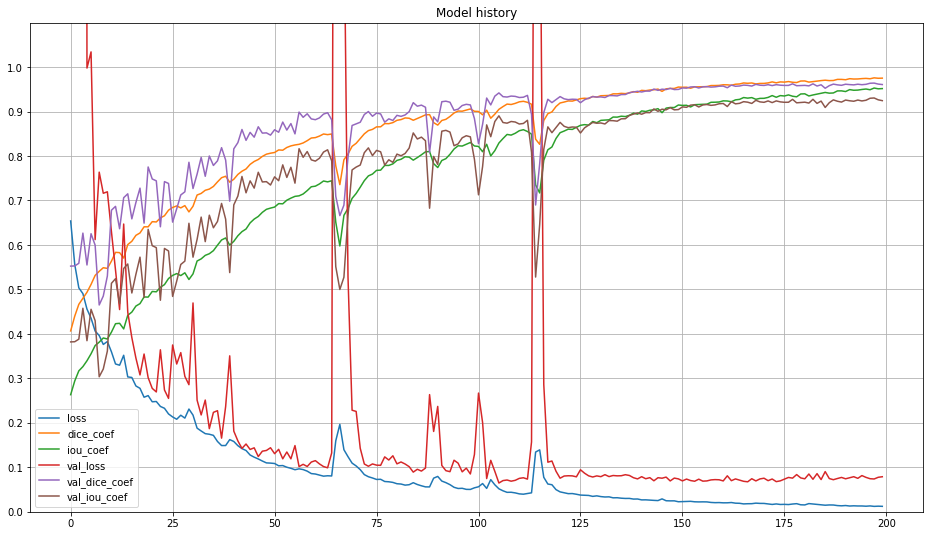

In [ ]:
plt.figure(figsize=(16,9))
for i in model_hist.history:
    plt.plot(model_hist.history[i],label=i)
plt.yticks(np.arange(0,1.1,0.1))
plt.title('Model history')
plt.legend()
plt.ylim(0,1.1)
plt.grid()
print('Max Dice: ', max(model_hist.history['val_dice_coef'])*100)

###Predict

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t0.jpg
Dice: 0.956450272990995
Jaccard: 0.9165354062545231


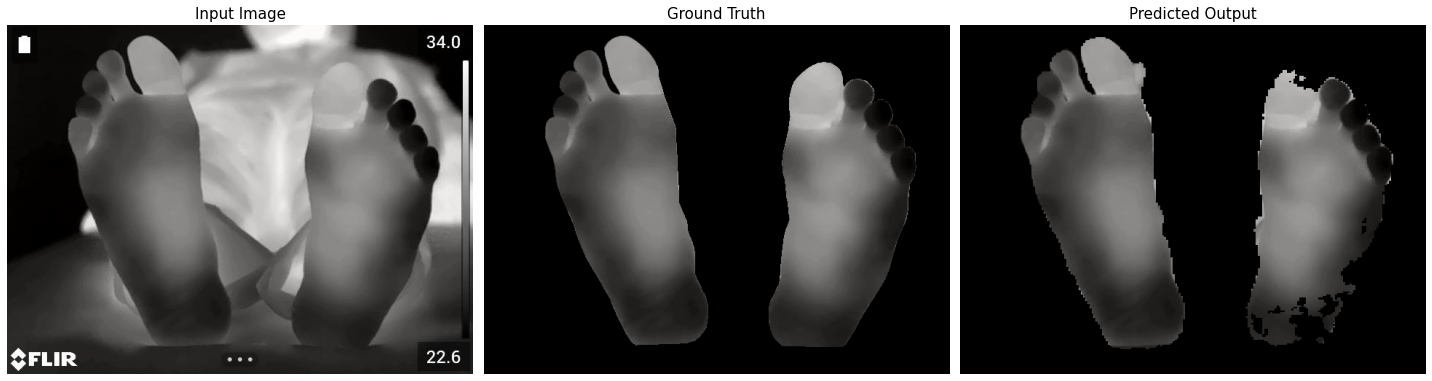

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t1.jpg
Dice: 0.9825691315487234
Jaccard: 0.9657355226939208


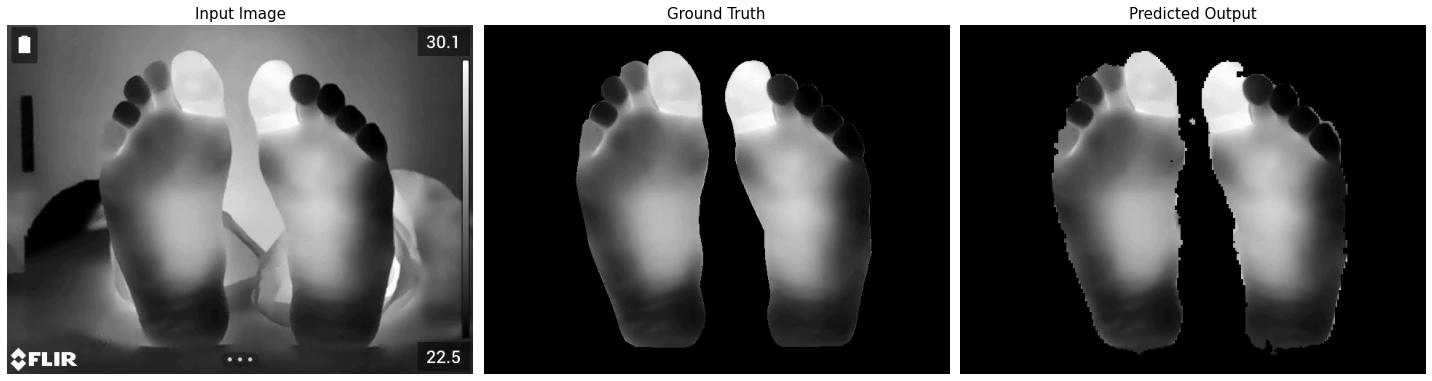

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t10.jpg
Dice: 0.9765741067544386
Jaccard: 0.9542206360027269


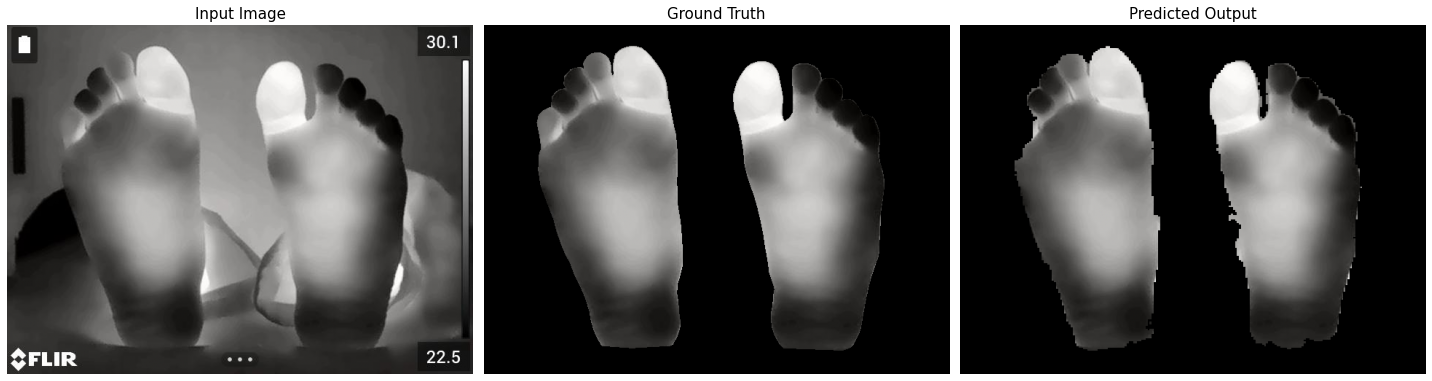

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t15.jpg
Dice: 0.9765951368561385
Jaccard: 0.9542607935788724


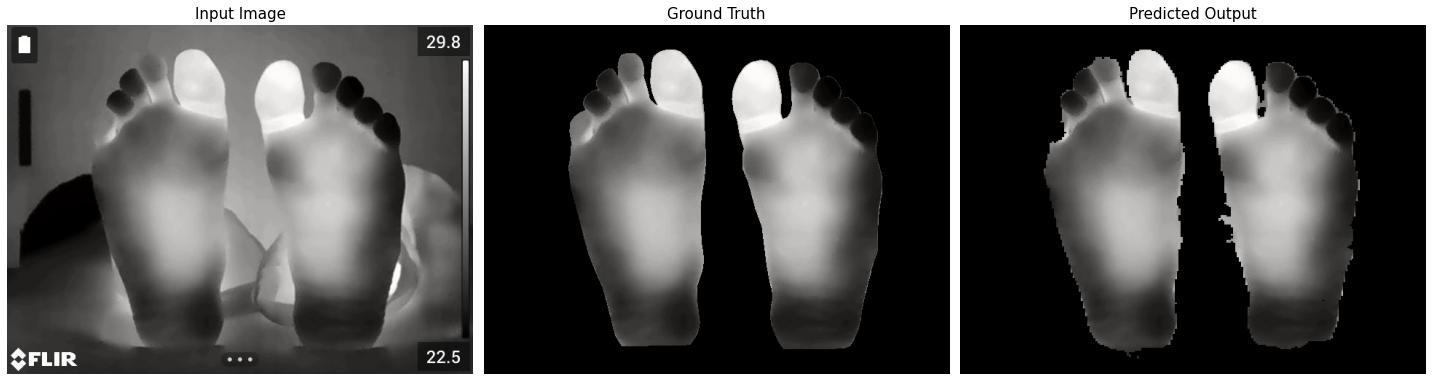

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t20.jpg
Dice: 0.961034896899369
Jaccard: 0.9249924699408179


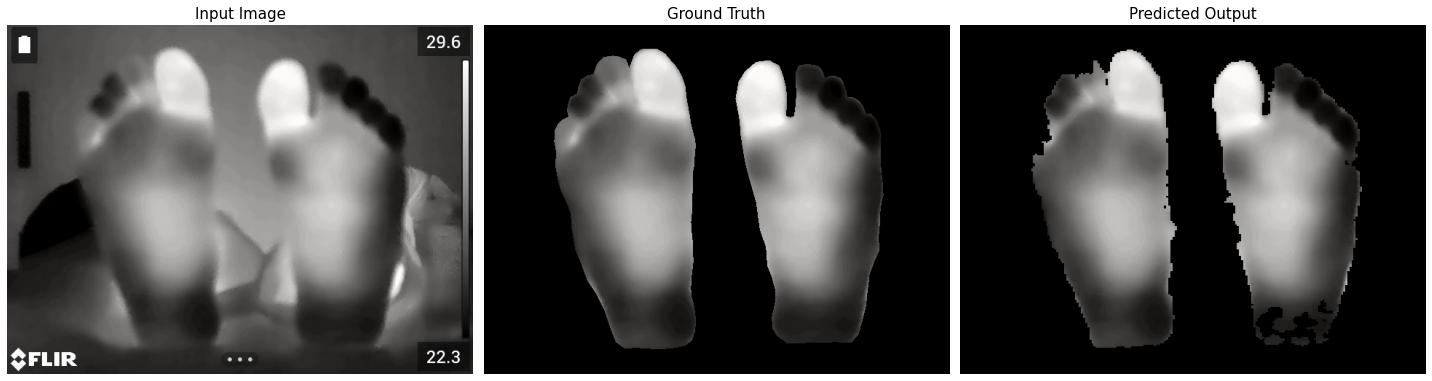

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t25.jpg
Dice: 0.9845976300875837
Jaccard: 0.9696625291238097


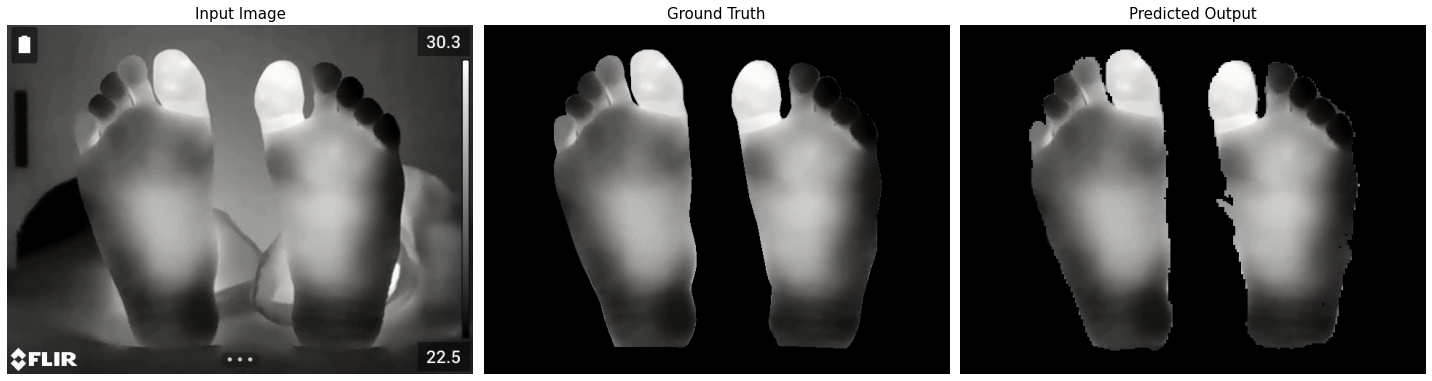

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t30.jpg
Dice: 0.9813070197930538
Jaccard: 0.9633000706392446


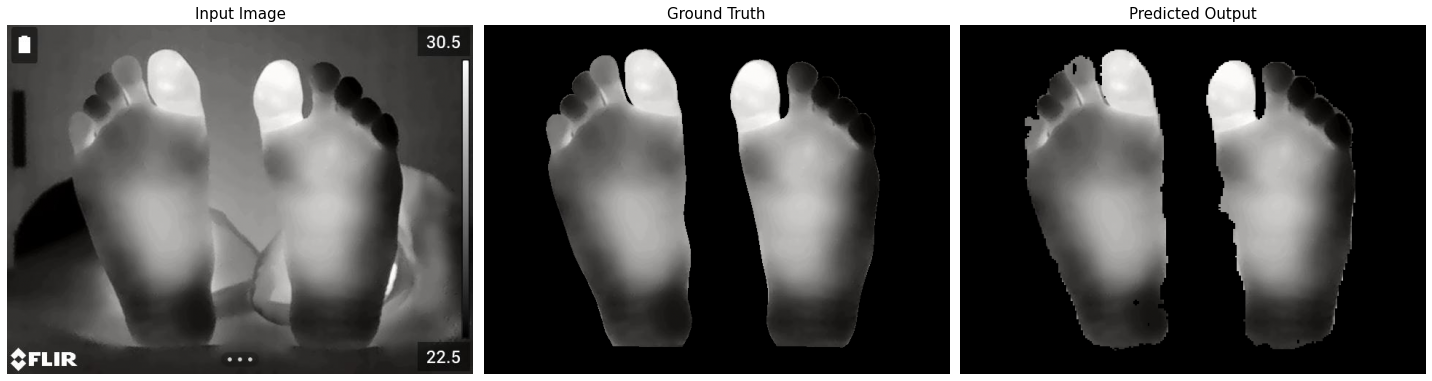

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t35.jpg
Dice: 0.9790588264501794
Jaccard: 0.9589767283515308


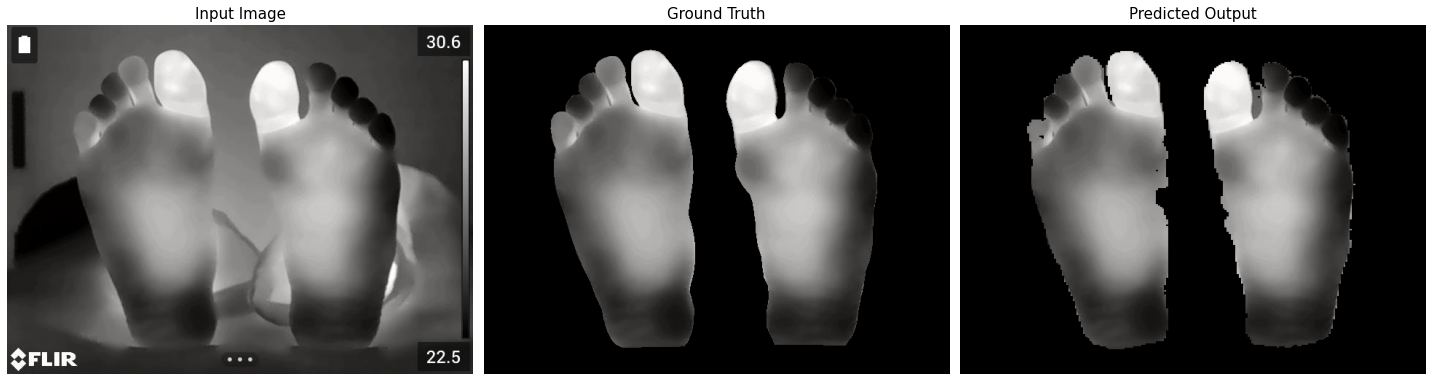

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t40.jpg
Dice: 0.9685416038336517
Jaccard: 0.9390021036558127


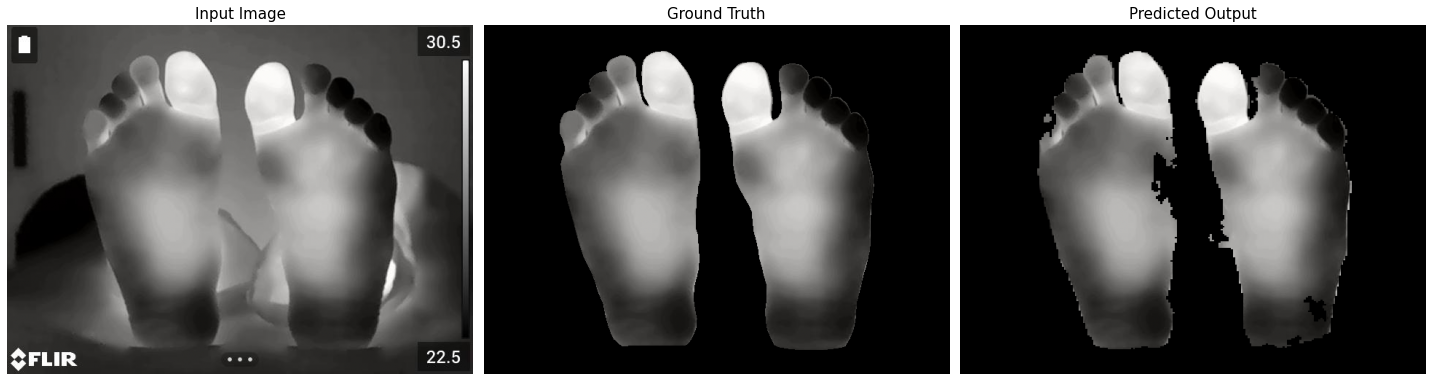

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t45.jpg
Dice: 0.9745840190162736
Jaccard: 0.9504279600570613


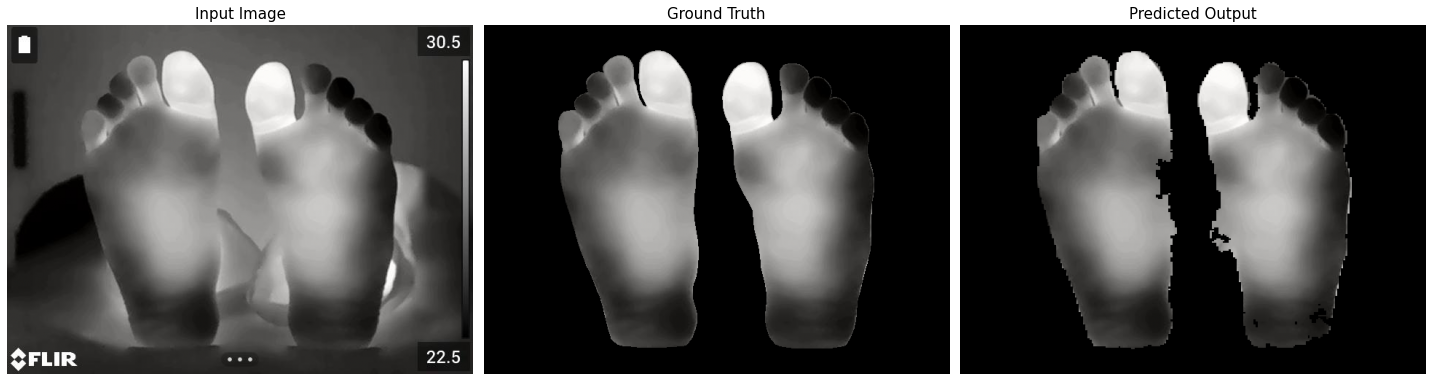

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t5.jpg
Dice: 0.9685433998919766
Jaccard: 0.9390054800081186


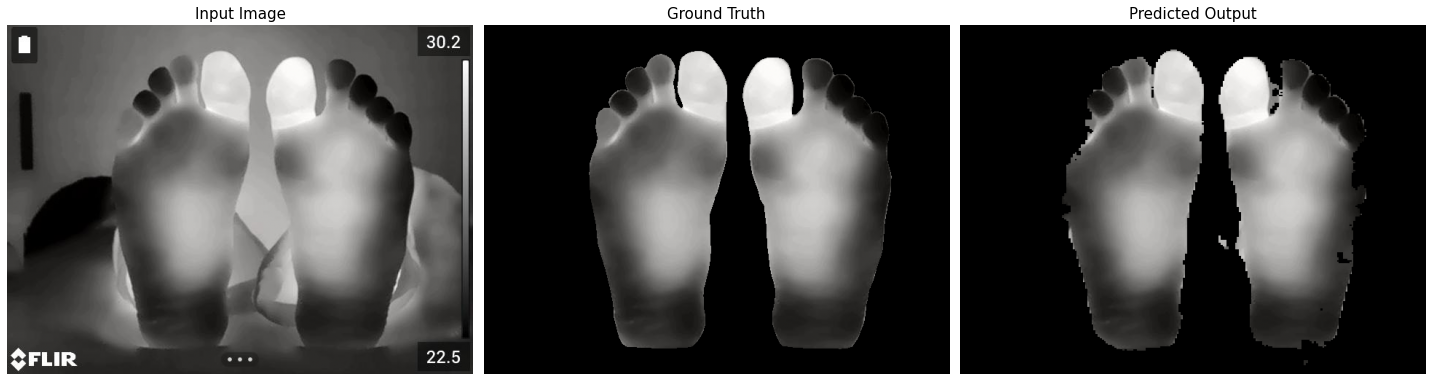

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t50.jpg
Dice: 0.9823586202861239
Jaccard: 0.9653288868445262


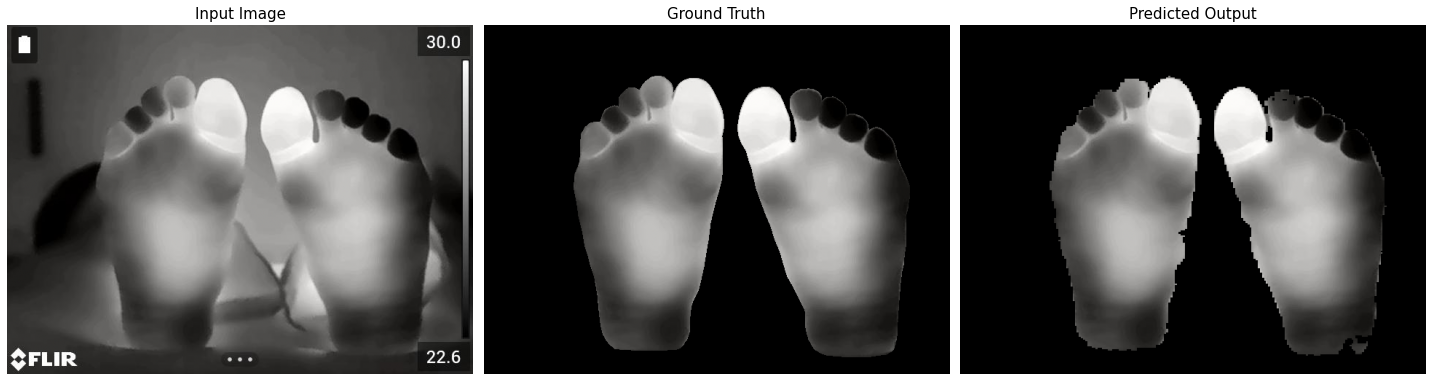

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t55.jpg
Dice: 0.9697923009268655
Jaccard: 0.941356099162699


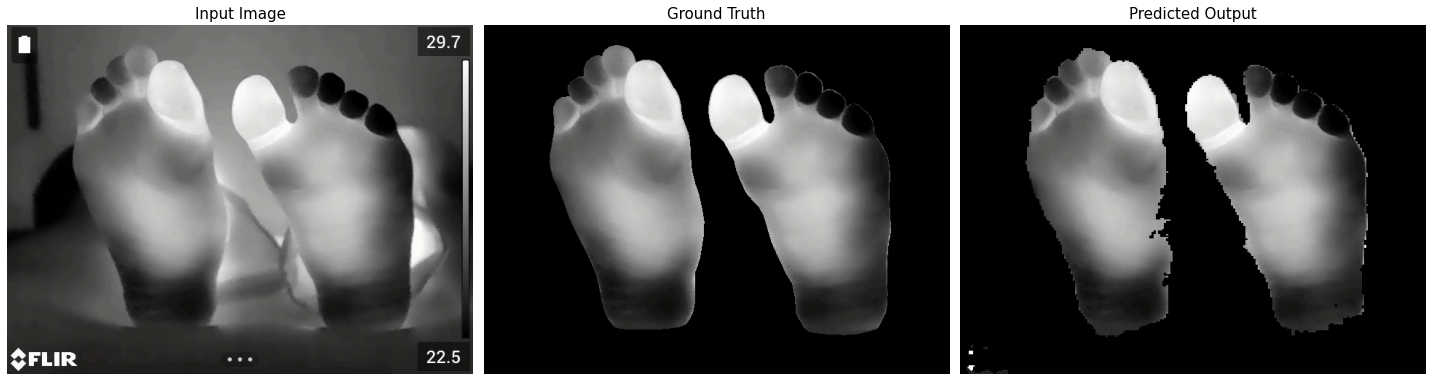

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t60.jpg
Dice: 0.9797770057364467
Jaccard: 0.9603557371726339


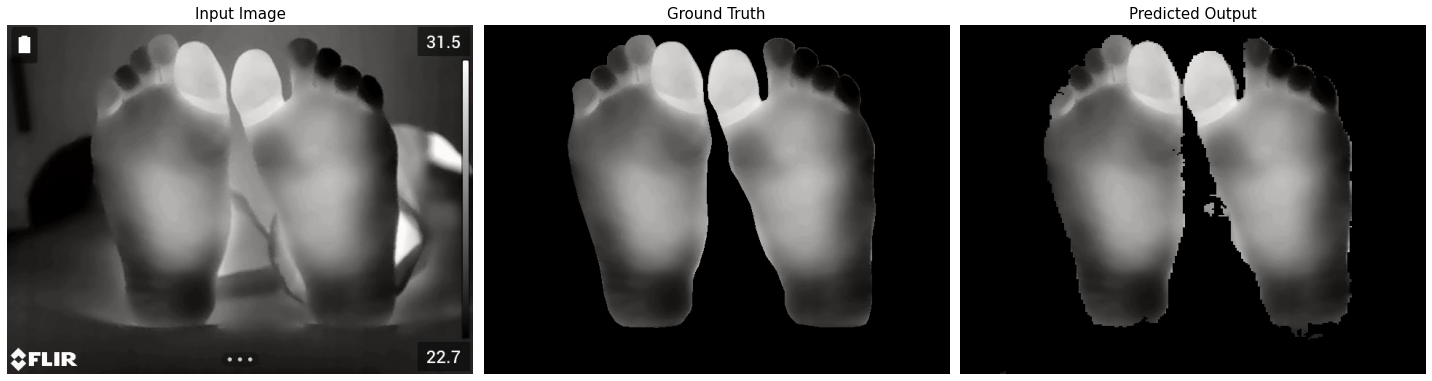

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t65.jpg
Dice: 0.971699030413378
Jaccard: 0.9449558632663762


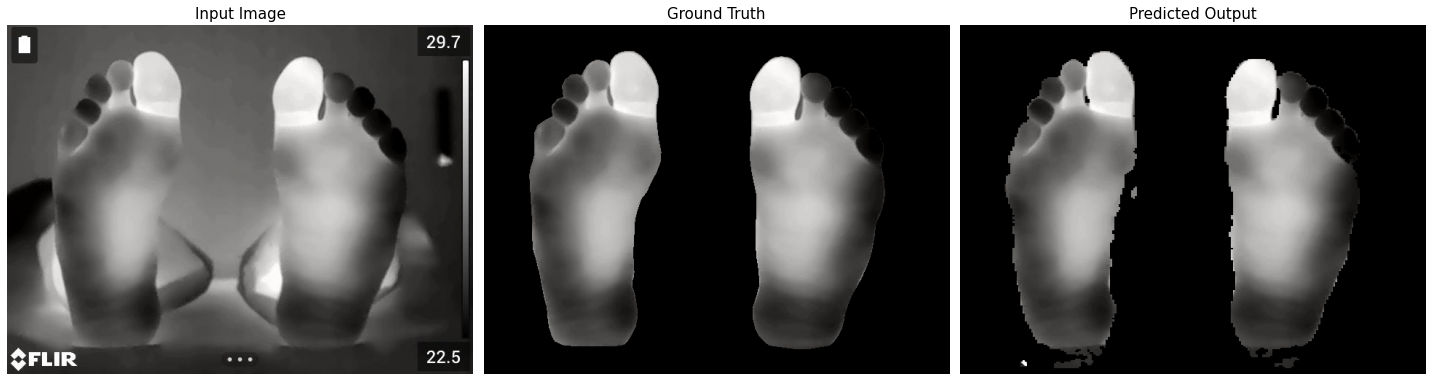

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t70.jpg
Dice: 0.9665003498177266
Jaccard: 0.9351724015071214


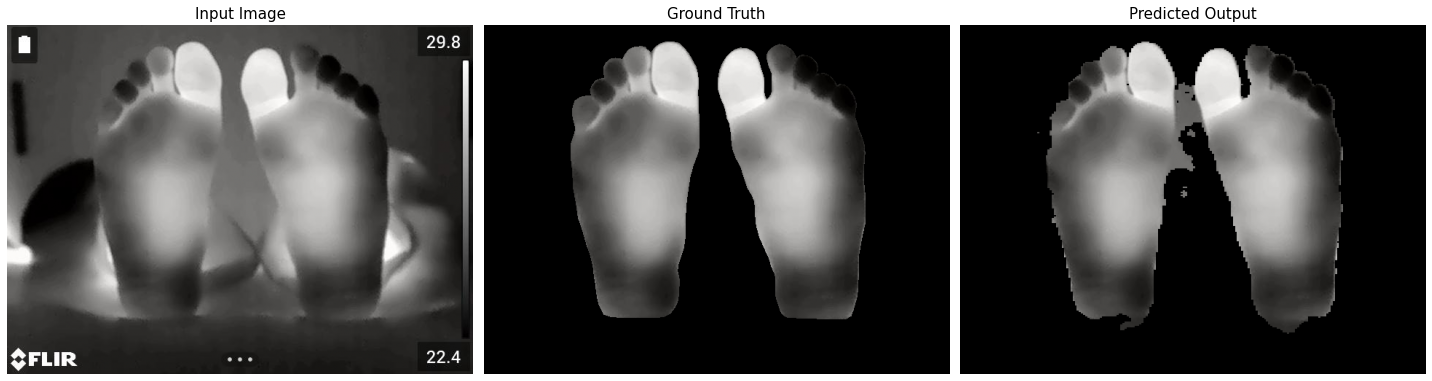

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t75.jpg
Dice: 0.955221329687233
Jaccard: 0.9142810404056928


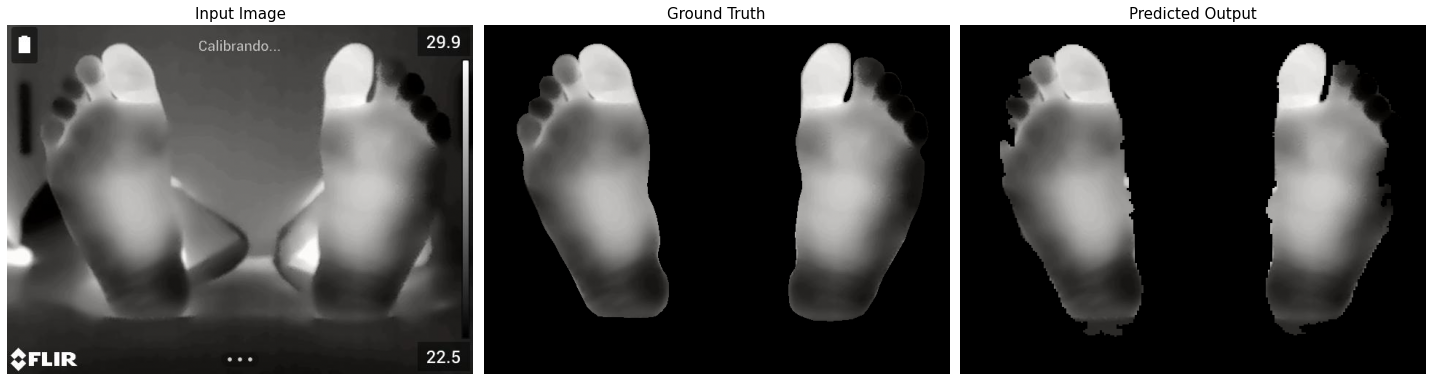

Displaying ./Dataset_3/Test/JPEGImages/marcos_loaiza_t80.jpg
Dice: 0.9587662841191067
Jaccard: 0.9207983467073784


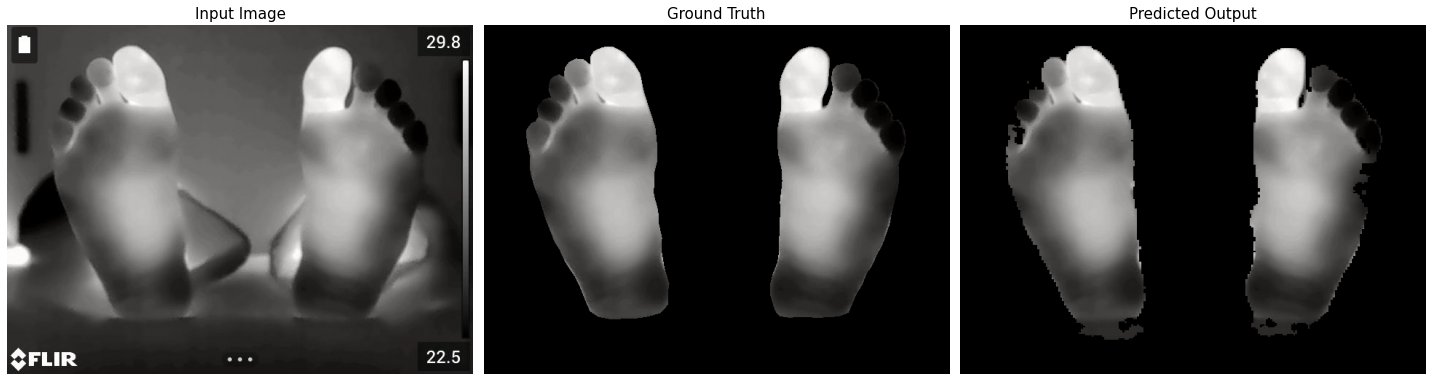

In [ ]:
img_size = 224
images_path = './Dataset_3/Test/JPEGImages' 
masks_path = './Dataset_3/Test/SegmentationClass'
imgs = os.listdir(images_path)
imgs.sort()
DiceList = []
JList = []
for n in range(len(imgs)):
    img_path = os.path.join(images_path, imgs[n])
    mask_path = os.path.join(masks_path, f"{imgs[n][:-3]}png")
   
    # Read the image
    img = plt.imread(img_path)/255.
    X = tf.convert_to_tensor(img)
    X = tf.image.resize(X,(img_size,img_size))
    X = tf.expand_dims(X,0)

    Y = plt.imread(mask_path)[:,:,0]

    # Make the prediction
    threshold = 0.5
    Y_pred = model.predict(X)   
    Y_pred = Y_pred/Y_pred.max()
    Y_pred = np.where(Y_pred>=threshold,1,0)
    # Resize
    Y_pred = cv2.resize(Y_pred[0], (img.shape[1],img.shape[0]), interpolation = cv2.INTER_NEAREST) # Resize the prediction to have the same dimensions as the input
    Dice = utils.DiceSimilarity(Y, Y_pred)
    DiceList += [Dice]
    Jaccard = utils.jaccard(Y, Y_pred)
    JList += [Jaccard]
    print(f"Displaying {img_path}\nDice: {Dice}\nJaccard: {Jaccard}")

    
    plt.figure(figsize=(20,9))

    if (img.shape[-1] == 3):
        mask = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
        pred_mask = np.copy(mask)
        mask[:,:,0] = mask[:,:,1] = mask[:,:,2] = Y[:,:]
        pred_mask[:,:,0] = pred_mask[:,:,1] = pred_mask[:,:,2] = Y_pred[:,:]
    else:
        mask = Y
        pred_mask = Y_pred

    plt.subplot(131)
    plt.imshow(img)
    plt.title("Input Image", fontsize=15)
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(img*mask,cmap='gray')
    plt.title("Ground Truth",fontsize=15)
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img*pred_mask,cmap='gray')
    plt.title("Predicted Output",fontsize=15)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

##Save the Models
Once a high performance model has been achieved, it can be saved for later use

In [ ]:
model.save('API_Model.h5')
Seg.save('Class_Model.h5')

### Benchmarking

In [ ]:
!python evaluate.py --model_path ./API_Model.h5 --model_name SegNet

2021-08-16 20:08:34.242257: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 20:08:36.533878: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 20:08:36.540132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 20:08:36.540567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-16 20:08:36.540604: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 20:08:36.542814: I tensorflow/stream_executor/platform/default